In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz

import gm2
import trfp

central_time = pytz.timezone('US/Central')

matplotlib.rc('xtick', labelsize=10)     
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('axes', labelsize=12)

# sns.set(style="darkgrid")
# sns.set(rc={'figure.figsize':(7,4.33)})

Welcome to JupyROOT 6.12/04


In [2]:
tr3956 = trfp.TrolleyRun(3956)

Reading event 8780/8781 99.99%     
loop done: 100%                                    
Reading event 2630/2634 99.85%  
loop done: 100%                                    
Finished calculating all moments for 4386 events.                                                     


In [3]:
def remove_trolley_effect_1(trolley_run):
    '''DOC STRING'''
    barcode = trfp.STATION_BARCODE_PHI
    
    trolley_effect_removed_df = trolley_run.moment_df.copy()
    
    for st in range(72):
        print '\rRemoving trolley image from station ' + str(st) + '.',
        for m in range(1,7):
            st_m = 'st' + str(st) + ",m" + str(m)
            
            # Unwrap the fixed probe data versus trolley position
            raw_data = trolley_run.moment_df[['tr_phi', st_m]].copy()
            raw_low = raw_data.copy()
            raw_high = raw_data.copy()
            raw_low['tr_phi'] = raw_low['tr_phi'] - 360
            raw_high['tr_phi'] = raw_high['tr_phi'] + 360
            unwrap_nomask_df = pd.concat([raw_low, raw_data, raw_high])
            
            unwrap_mask_df = unwrap_nomask_df.copy()
            mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-2) & (unwrap_nomask_df['tr_phi']<barcode[st]+5) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5-360) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+360))
            unwrap_mask_df[st_m] = unwrap_nomask_df[st_m].mask(mask)
            unwrap_mask_df['tr_phi'] = unwrap_nomask_df['tr_phi']
            
            unwrap_filled_df = unwrap_mask_df.copy()
            temp = unwrap_filled_df.rolling(int(100),win_type='triang',min_periods=1,center=True).mean()
            unwrap_filled_df[st_m] = unwrap_filled_df[st_m].mask(mask, temp[st_m])
            
            length = raw_data.shape[0]
            filled_df = unwrap_filled_df.iloc[length:2*length,:]
            
            trolley_effect_removed_df[st_m] = filled_df[st_m]
    
    print '\rFinished removing trolley images from ' + str(length) + ' events.'
    return trolley_effect_removed_df

def remove_trolley_effect_2(trolley_run):
    '''DOC STRING'''
    barcode = trfp.STATION_BARCODE_PHI
    
    trolley_effect_removed_df = trolley_run.moment_df.copy()
    
    for st in range(72):
        print '\rRemoving trolley image from station ' + str(st) + '.',
        for m in range(1,7):
            st_m = 'st' + str(st) + ",m" + str(m)
            
            # Unwrap the fixed probe data versus trolley position
            raw_data = trolley_run.moment_df[['tr_phi', st_m]].copy()
            raw_low = raw_data.copy()
            raw_high = raw_data.copy()
            raw_low['tr_phi'] = raw_low['tr_phi'] - 360
            raw_high['tr_phi'] = raw_high['tr_phi'] + 360
            unwrap_nomask_df = pd.concat([raw_low, raw_data, raw_high])
            
            unwrap_mask_df = unwrap_nomask_df.copy()
            mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-2) & (unwrap_nomask_df['tr_phi']<barcode[st]+5) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5-360) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+360))
            unwrap_mask_df[st_m] = unwrap_nomask_df[st_m].mask(mask)
            unwrap_mask_df['tr_phi'] = unwrap_nomask_df['tr_phi']
            
            unwrap_filled_df = unwrap_mask_df.copy()
            temp = unwrap_filled_df.rolling(int(100),win_type='triang',min_periods=1,center=True).mean()
            temp = temp.rolling(int(100),win_type='triang',min_periods=1,center=True).mean()
            unwrap_filled_df[st_m] = unwrap_filled_df[st_m].mask(mask, temp[st_m])
            
            length = raw_data.shape[0]
            filled_df = unwrap_filled_df.iloc[length:2*length,:]
            
            trolley_effect_removed_df[st_m] = filled_df[st_m]
    
    print '\rFinished removing trolley images from ' + str(length) + ' events.'
    return trolley_effect_removed_df

In [4]:
corrected_df_1 = remove_trolley_effect_1(tr3956)
corrected_df_2 = remove_trolley_effect_2(tr3956)

Finished removing trolley images from 4386 events.            
Finished removing trolley images from 4386 events.                        


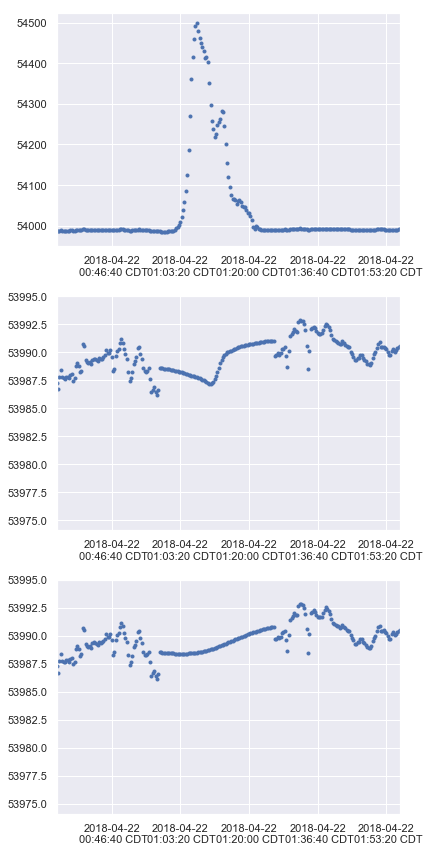

In [17]:
sns.set(style="darkgrid")

st_m = 'st66,m1'

fig, ax = plt.subplots(3,1)

t_min = np.min(tr3956.moment_df.index.values)
t_max = np.max(tr3956.moment_df.index.values)
t_start = t_max - 0.2*(t_max - t_min)
t_end = t_start + 250

plt.sca(ax[0])
plt.plot(tr3956.moment_df.index.values,tr3956.moment_df[st_m], '.')
xticks = ax[0].get_xticks()
ax[0].set_xlim((t_start,t_end))
ax[0].set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z') for tm in xticks], rotation=0)

plt.sca(ax[1])
plt.plot(corrected_df_1.index.values,corrected_df_1[st_m], '.')
xticks = ax[1].get_xticks()
ax[1].set_xlim((t_start,t_end))
ax[1].set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z') for tm in xticks], rotation=0)

plt.sca(ax[2])
plt.plot(corrected_df_2.index.values,corrected_df_2[st_m], '.')
xticks = ax[2].get_xticks()
ax[2].set_xlim((t_start,t_end))
ax[2].set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z') for tm in xticks], rotation=0)

fig.set_size_inches(6, 12)
fig.tight_layout()

